<a href="https://colab.research.google.com/github/bafanaS/dim-reduction-with-cnn-lstm/blob/main/Dimensionality_Reduction_2_Classes%2C_Real_and_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning & Processing

In [1]:
import numpy as np
import pandas as pd

In [2]:


from matplotlib import rcParams # rcParams is a file that specifies Matplotlib style defaults
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
alldat = np.load(fname, allow_pickle=True)['dat']

In [7]:
participant=4

# Real & Imag Reformatting

In [8]:
num_dicts = alldat.shape[0]

arr_new_real = np.empty((1, 2, 2000, 46))

In [9]:
# Create array for real movements. You'll do the same for imaginary.

from scipy import signal
import numpy as np

num_dicts = alldat.shape[0]

dat1 = alldat[participant][0]
V = dat1['V'].astype('float32')[:, :46]

b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = V/V.mean(0)

nt, nchan = V.shape
nstim = len(dat1['t_on'])
trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

# AVERAGE OVER MOVEMENTS
V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

arr_new_real[i][0] = V_tongue
arr_new_real[i][1] = V_hand

In [10]:
num_dicts = alldat.shape[0]

arr_new_imag = np.empty((1, 2, 2000, 46))

In [11]:
# Create array for real movements. You'll do the same for imaginary.

from scipy import signal
import numpy as np

num_dicts = alldat.shape[0]

dat1 = alldat[participant][1]
V = dat1['V'].astype('float32')[:, :46]

b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = V/V.mean(0)

nt, nchan = V.shape
nstim = len(dat1['t_on'])
trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))
V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

arr_new_imag[i][0] = V_tongue
arr_new_imag[i][1] = V_hand

In [12]:
print(arr_new_real.shape)
real_reshaped = arr_new_real.swapaxes(2, 3)
print(real_reshaped.shape)
real_final = real_reshaped.reshape(2 * 1 * 46, 2000)
print(real_final.shape)


print(arr_new_imag.shape)
imag_reshaped = arr_new_imag.swapaxes(2, 3)
print(imag_reshaped.shape)
imag_final = imag_reshaped.reshape(2 * 1 * 46, 2000)
print(imag_final.shape)

(1, 2, 2000, 46)
(1, 2, 46, 2000)
(92, 2000)
(1, 2, 2000, 46)
(1, 2, 46, 2000)
(92, 2000)


In [13]:
full_arr = np.concatenate([real_final, imag_final], axis=0)
full_arr.shape

(184, 2000)

In [14]:
labels = np.concatenate([np.zeros(shape=real_final.shape[0]), np.ones(shape=imag_final.shape[0])])
labels.shape

(184,)

## PCA: FashionMNIST

In [15]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [16]:
idx = np.random.permutation(len(full_arr))
full_arr, labels = full_arr[idx], labels.flatten()[idx]

In [17]:
full_trained = StandardScaler().fit_transform(full_arr) #(mean = 0 and variance = 1)

In [18]:
from sklearn.decomposition import PCA

variance = 0.9
pca = PCA(variance)

In [19]:
pca.fit(full_trained)

PCA(n_components=0.9)

In [20]:
pca.singular_values_

array([491.2146751 , 248.70662318, 123.81897818,  88.87901268,
        76.54377435])

In [21]:
pca.n_components_

5

In [22]:
full_trained_reduced = pca.transform(full_trained)

In [23]:
full_trained_reduced.shape

(184, 5)

In [24]:
labels.shape

(184,)

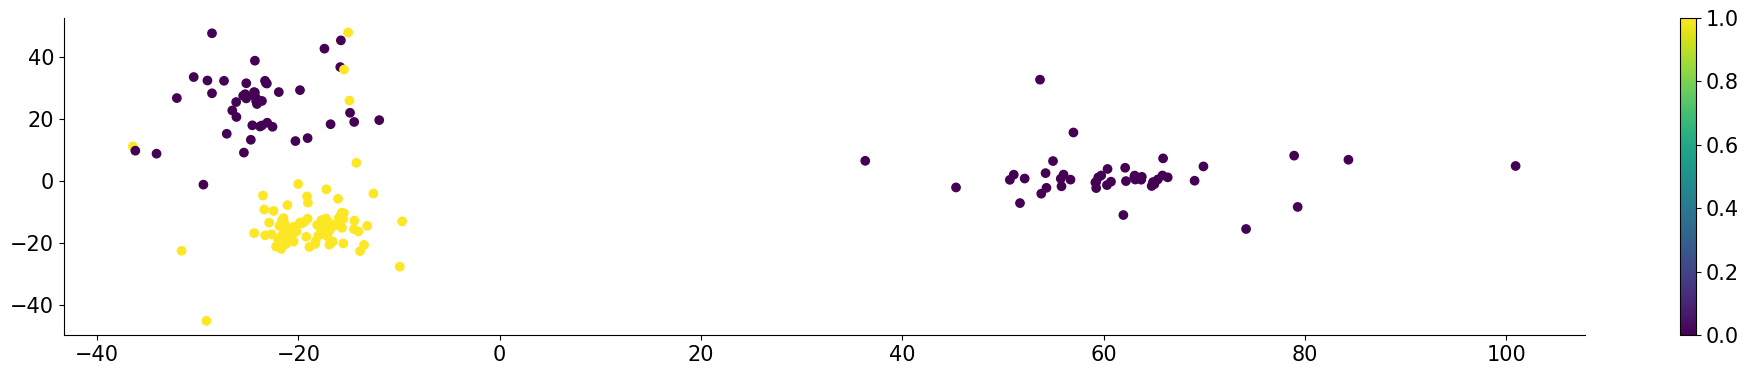

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

im = ax.scatter(full_trained_reduced[0:750, 0], full_trained_reduced[0:750, 1], c = labels.flatten()[0:750])
fig.colorbar(im, ax=ax)

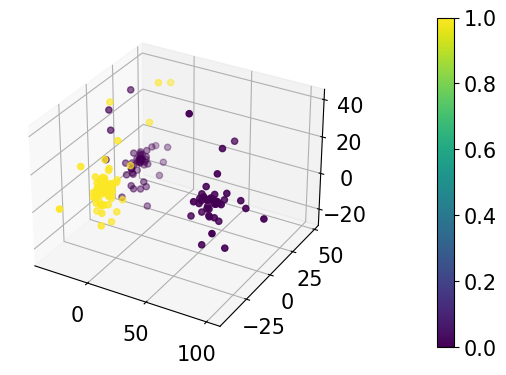

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

im = ax.scatter(full_trained_reduced[0:750, 0], full_trained_reduced[0:750, 1], full_trained_reduced[0:750, 2], c = labels.flatten()[0:750])
fig.colorbar(im, ax=ax)

## t-SNE: FashionMNIST

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_train_reduced = tsne.fit_transform(full_trained)

In [28]:
X_train_reduced.shape

(184, 2)

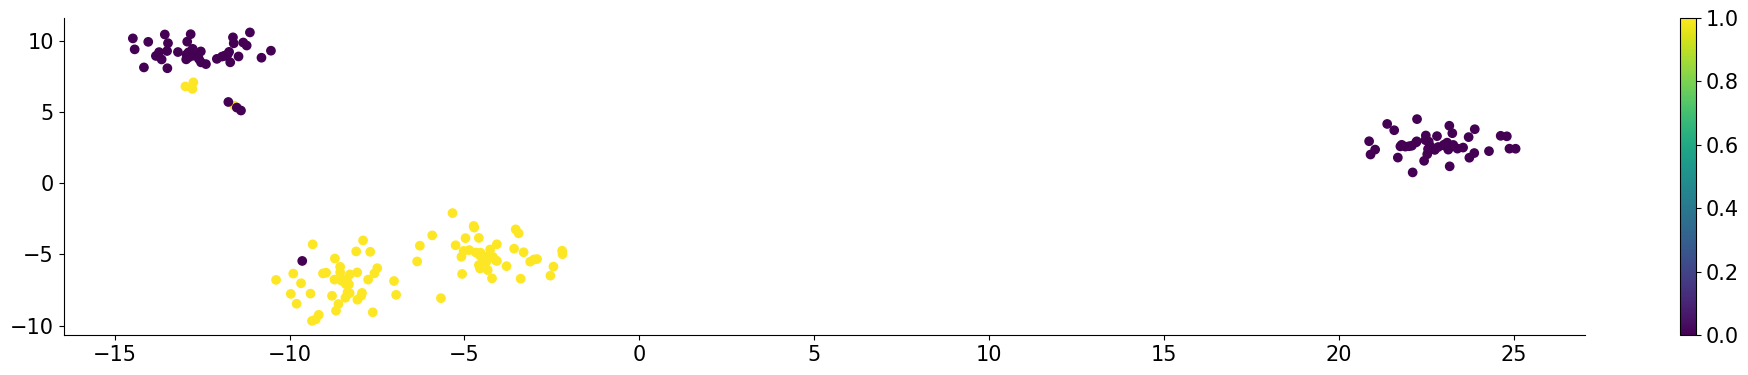

In [29]:
fig = plt.figure()
ax = fig.add_subplot()

im = ax.scatter(X_train_reduced[0:750, 0], X_train_reduced[0:750, 1], c = labels.flatten()[0:750])
fig.colorbar(im, ax=ax)

In [30]:
tsne = TSNE(n_components=3)
X_train_reduced = tsne.fit_transform(full_trained)

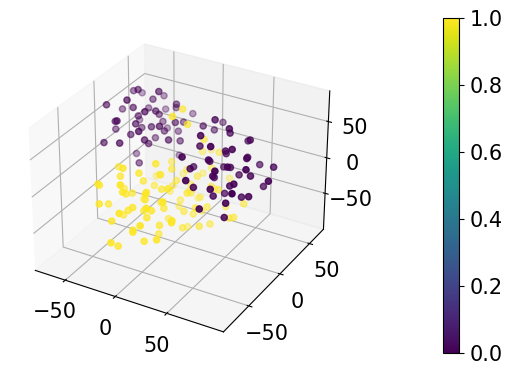

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

im = ax.scatter(X_train_reduced[0:750, 0], X_train_reduced[0:750, 1], X_train_reduced[0:750, 2], c = labels.flatten()[0:750])
fig.colorbar(im, ax=ax)

## UMAP: FashionMNIST

In [32]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=bd90787b0978a00d8fc99133b848731c8dd52135e4e1532a800eac058e66109b
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=756ec6df6e2413b487c93a3e9bea3fddc0d79d77d923ed34a9fece735e522937
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [33]:
from umap import UMAP

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

X_train_reduced = umap_2d.fit_transform(full_trained)
X_train_reduced = umap_3d.fit_transform(full_trained)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [34]:
X_train_reduced.shape

(184, 3)

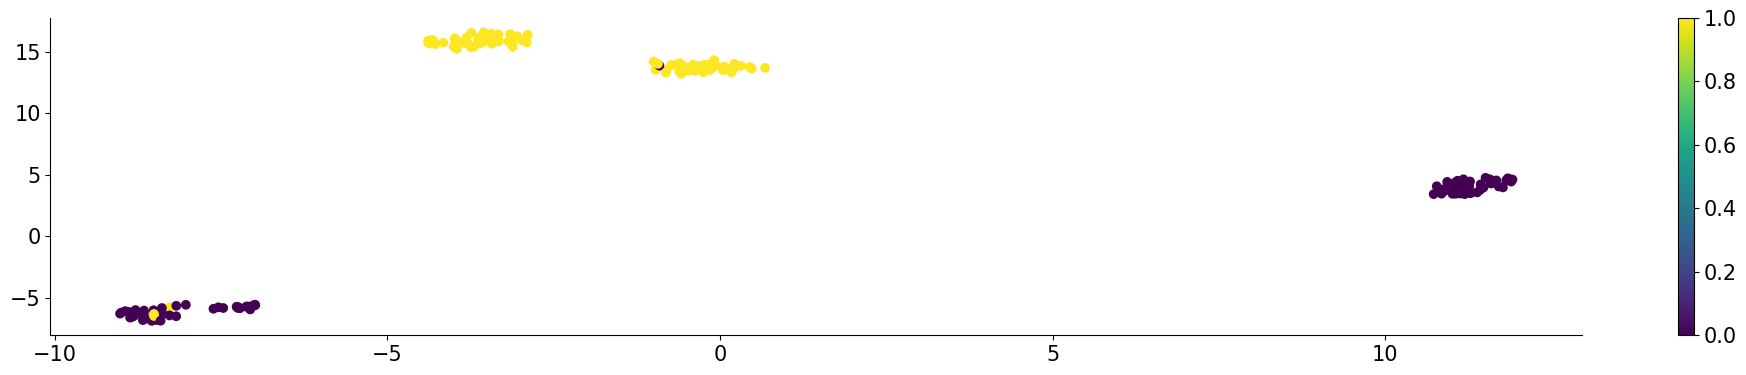

In [35]:
fig = plt.figure()
ax = fig.add_subplot()

im = ax.scatter(X_train_reduced[0:750, 0], X_train_reduced[0:750, 1], c = labels.flatten()[0:750])
fig.colorbar(im, ax=ax)

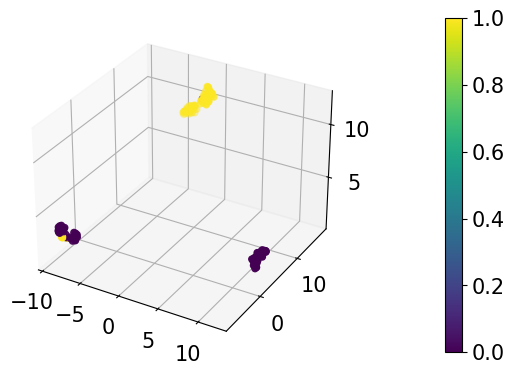

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

im = ax.scatter(X_train_reduced[0:750, 0], X_train_reduced[0:750, 1], X_train_reduced[0:750, 2], c = labels.flatten()[0:750])
fig.colorbar(im, ax=ax)

In [43]:
!pip install sklearn

  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [38]:
X_train_reduced[:, 0:2].shape

(184, 2)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_reduced[:, 0:2], labels.flatten(), test_size=0.2, random_state=42)

Text(0.5, 1.0, "2-Class Classification (k = 4, weights = 'uniform')")

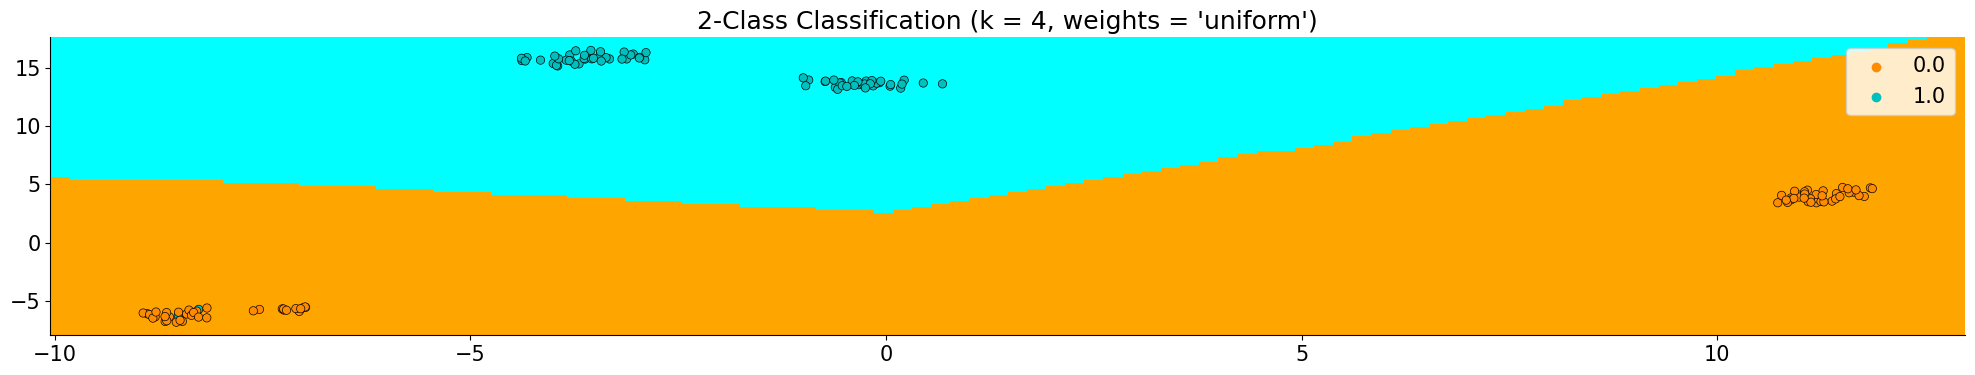

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn import datasets, neighbors
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 4
clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform")
clf.fit(X_train, y_train)

# Create color maps
cmap_light = ListedColormap(["orange", "cyan"])
cmap_bold = ["darkorange", "c"]

_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    )

# Plot also the training points
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
  )

plt.title(
    "2-Class Classification (k = %i, weights = '%s')" % (n_neighbors, "uniform")
    )

In [41]:
clf.score(X_train, y_train)

0.9863945578231292

In [42]:
clf.score(X_test, y_test)

0.918918918918919